In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
def process_files(directory):
    output_cols = ["source", "species", "N", "Cab", "Ccx", "Cw", "Cm", "Cbrown", "Canth", "Cp", "CBC", "LAI", "LIDF",
                   "ALIA", "Hspot", "psi", "tts", "tto", "psoil",
                   "433-453", "457.5-522.5", "542.5-577.5", "650-680", "697.5-712.5", "732.5-747.5", "773-793",
                   "784.5-899.5", "855-875", "935-955", "1360-1390", "1565-1655", "2100-2280"]

    non_numeric_cols = ["species", "N", "Cab", "Ccx", "Cw", "Cm", "Cbrown", "Canth", "Cp", "CBC", "LAI", "LIDF", "ALIA",
                        "Hspot", "psi", "tts", "tto", "psoil"]

    output_df = pd.DataFrame(columns=output_cols)

    def is_numeric_col(col):
        try:
            float(col)
            return True
        except ValueError:
            return False

    def is_invalid(val, col_name):
        if col_name == "species":
            return False if isinstance(val, str) and val.strip() != "" else True
        if isinstance(val, str):
            if val in ["#VALUE!", "NA"]:
                return True
            try:
                numeric_val = float(val)
                if numeric_val <= 0:
                    return True
            except ValueError:
                return True
        elif pd.isna(val) or val <= 0:
            return True
        return False

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if filename.endswith('.csv'):
            df = pd.read_csv(filepath)
        elif filename.endswith('.xlsx') or filename.endswith('.xls'):
            try:
                df = pd.read_excel(filepath, engine='openpyxl')
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
                continue
        else:
            continue

        numeric_columns = [col for col in df.columns if is_numeric_col(col)]
        sample = df[numeric_columns].iloc[0]
        if np.any(sample > 1):
            print("Need / 100.0")
            df[numeric_columns] = df[numeric_columns] / 100.0
            
        # After adjusting the scale (if necessary), multiply by 10000
        df[numeric_columns] = df[numeric_columns] * 10000

        for _, row in df.iterrows():
            new_row = {"source": filename}
            for col in non_numeric_cols:
                value = row[col] if col in df.columns else None
                new_row[col] = None if is_invalid(value, col) else value

            for num_range in output_cols[len(non_numeric_cols) + 1:]:
                start, end = [float(x) for x in num_range.split('-')]
                relevant_cols = []
                for col in numeric_columns:
                    try:
                        if start <= float(col) <= end:
                            relevant_cols.append(col)
                    except ValueError:
                        continue
                new_row[num_range] = row[relevant_cols].mean() if relevant_cols else None

            output_df.loc[len(output_df)] = new_row
        print("Finish processing " + filename)
    
    existing_col_labels = ["433-453", "457.5-522.5", "542.5-577.5", "650-680", "697.5-712.5", "732.5-747.5", "773-793",
                           "784.5-899.5", "855-875", "935-955", "1360-1390", "1565-1655", "2100-2280"]
    new_col_labels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
    
    if len(existing_col_labels) != len(new_col_labels):
        print("Warning: The number of existing column labels does not match the number of new column labels.")
        
    col_mapping = dict(zip(existing_col_labels, new_col_labels))
    valid_col_mapping = {old: new for old, new in col_mapping.items() if old in output_df.columns}
    output_df.rename(columns=valid_col_mapping, inplace=True)

    output_df.to_csv(os.path.join(directory, "processed_data.csv"), index=False)
    print("Processing complete! Output saved to processed_data.csv")

In [5]:
# Execute the function
process_files(r"D:\二学位非软件文件\GREAT\refine_dataset")
# process_files(r"C:\Users\Administrator\Desktop\training data\test")

Finish processing angers-leaf-optical-properties-database--2003-.csv
Finish processing leaf-optical-properties-experiment-database--lopex93-.csv
Need / 100.0
Finish processing Momtanu.csv
Processing complete! Output saved to processed_data.csv


In [12]:
def plot_and_fit(data_path):
    # Read the csv file
    df = pd.read_csv(data_path)

    # Columns to analyze
    columns = ["N", "Cab", "Ccx", "Cw", "Cm", "Canth", "Cp", "CBC", "LAI"]

    # Create a DataFrame to store fit results
    results = {'Column': [], 'Mean (mu)': [], 'Standard Deviation (std)': [], 'Max': [], 'Min': []}

    # Create a 3x3 subplot matrix
    fig, axes = plt.subplots(4, 3, figsize=(18,18), facecolor='white')
    axes = axes.ravel()  # Flatten the 3x3 matrix

    for i, col in enumerate(columns):
        ax = axes[i]
        data = df[col].dropna()  # Remove NaN values
        
        # Remove outliers using IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]

        # Shade the region between Q1 and Q3
        ax.axvspan(Q1, Q3, color='yellow', alpha=0.2, label='IQR')

        # Plot histogram with improved aesthetics
        ax.hist(data, bins=30, density=True, alpha=0.6, color='#1f77b4', edgecolor='black', linewidth=0.5)

        # Fit data to a normal distribution
        mu, std = norm.fit(data)
        results['Column'].append(col)
        results['Mean (mu)'].append(mu)
        results['Standard Deviation (std)'].append(std)
        results['Max'].append(data.max())
        results['Min'].append(data.min())

        # Plot the fitted curve with improved aesthetics
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p, 'k--', linewidth=2)
        title = "{}: mu = {:.6f}, std = {:.6f}".format(col, mu, std)

        # Annotate with max, min, mean, and standard deviation values
        ax.annotate(f'Max: {data.max():.6f}', xy=(0.7, 0.9), xycoords='axes fraction')
        ax.annotate(f'Min: {data.min():.6f}', xy=(0.7, 0.85), xycoords='axes fraction')
        ax.annotate(f'Mean: {data.mean():.6f}', xy=(0.7, 0.8), xycoords='axes fraction')
        ax.annotate(f'Std: {data.std():.6f}', xy=(0.7, 0.75), xycoords='axes fraction')

        ax.set_title(title)
        ax.legend()

    plt.tight_layout()
    plt.show()
    
    # Convert results to a DataFrame and style
    results_df = pd.DataFrame(results)
    styled = results_df.style.format({
        'Mean (mu)': "{:.6f}",
        'Standard Deviation (std)': "{:.6f}",
        'Max': "{:.6f}",
        'Min': "{:.6f}"
    })
    # Save styled results to Excel
    styled.to_excel("D:\\二学位非软件文件\\GREAT\\dataset\\fit_results.xlsx", index=False)

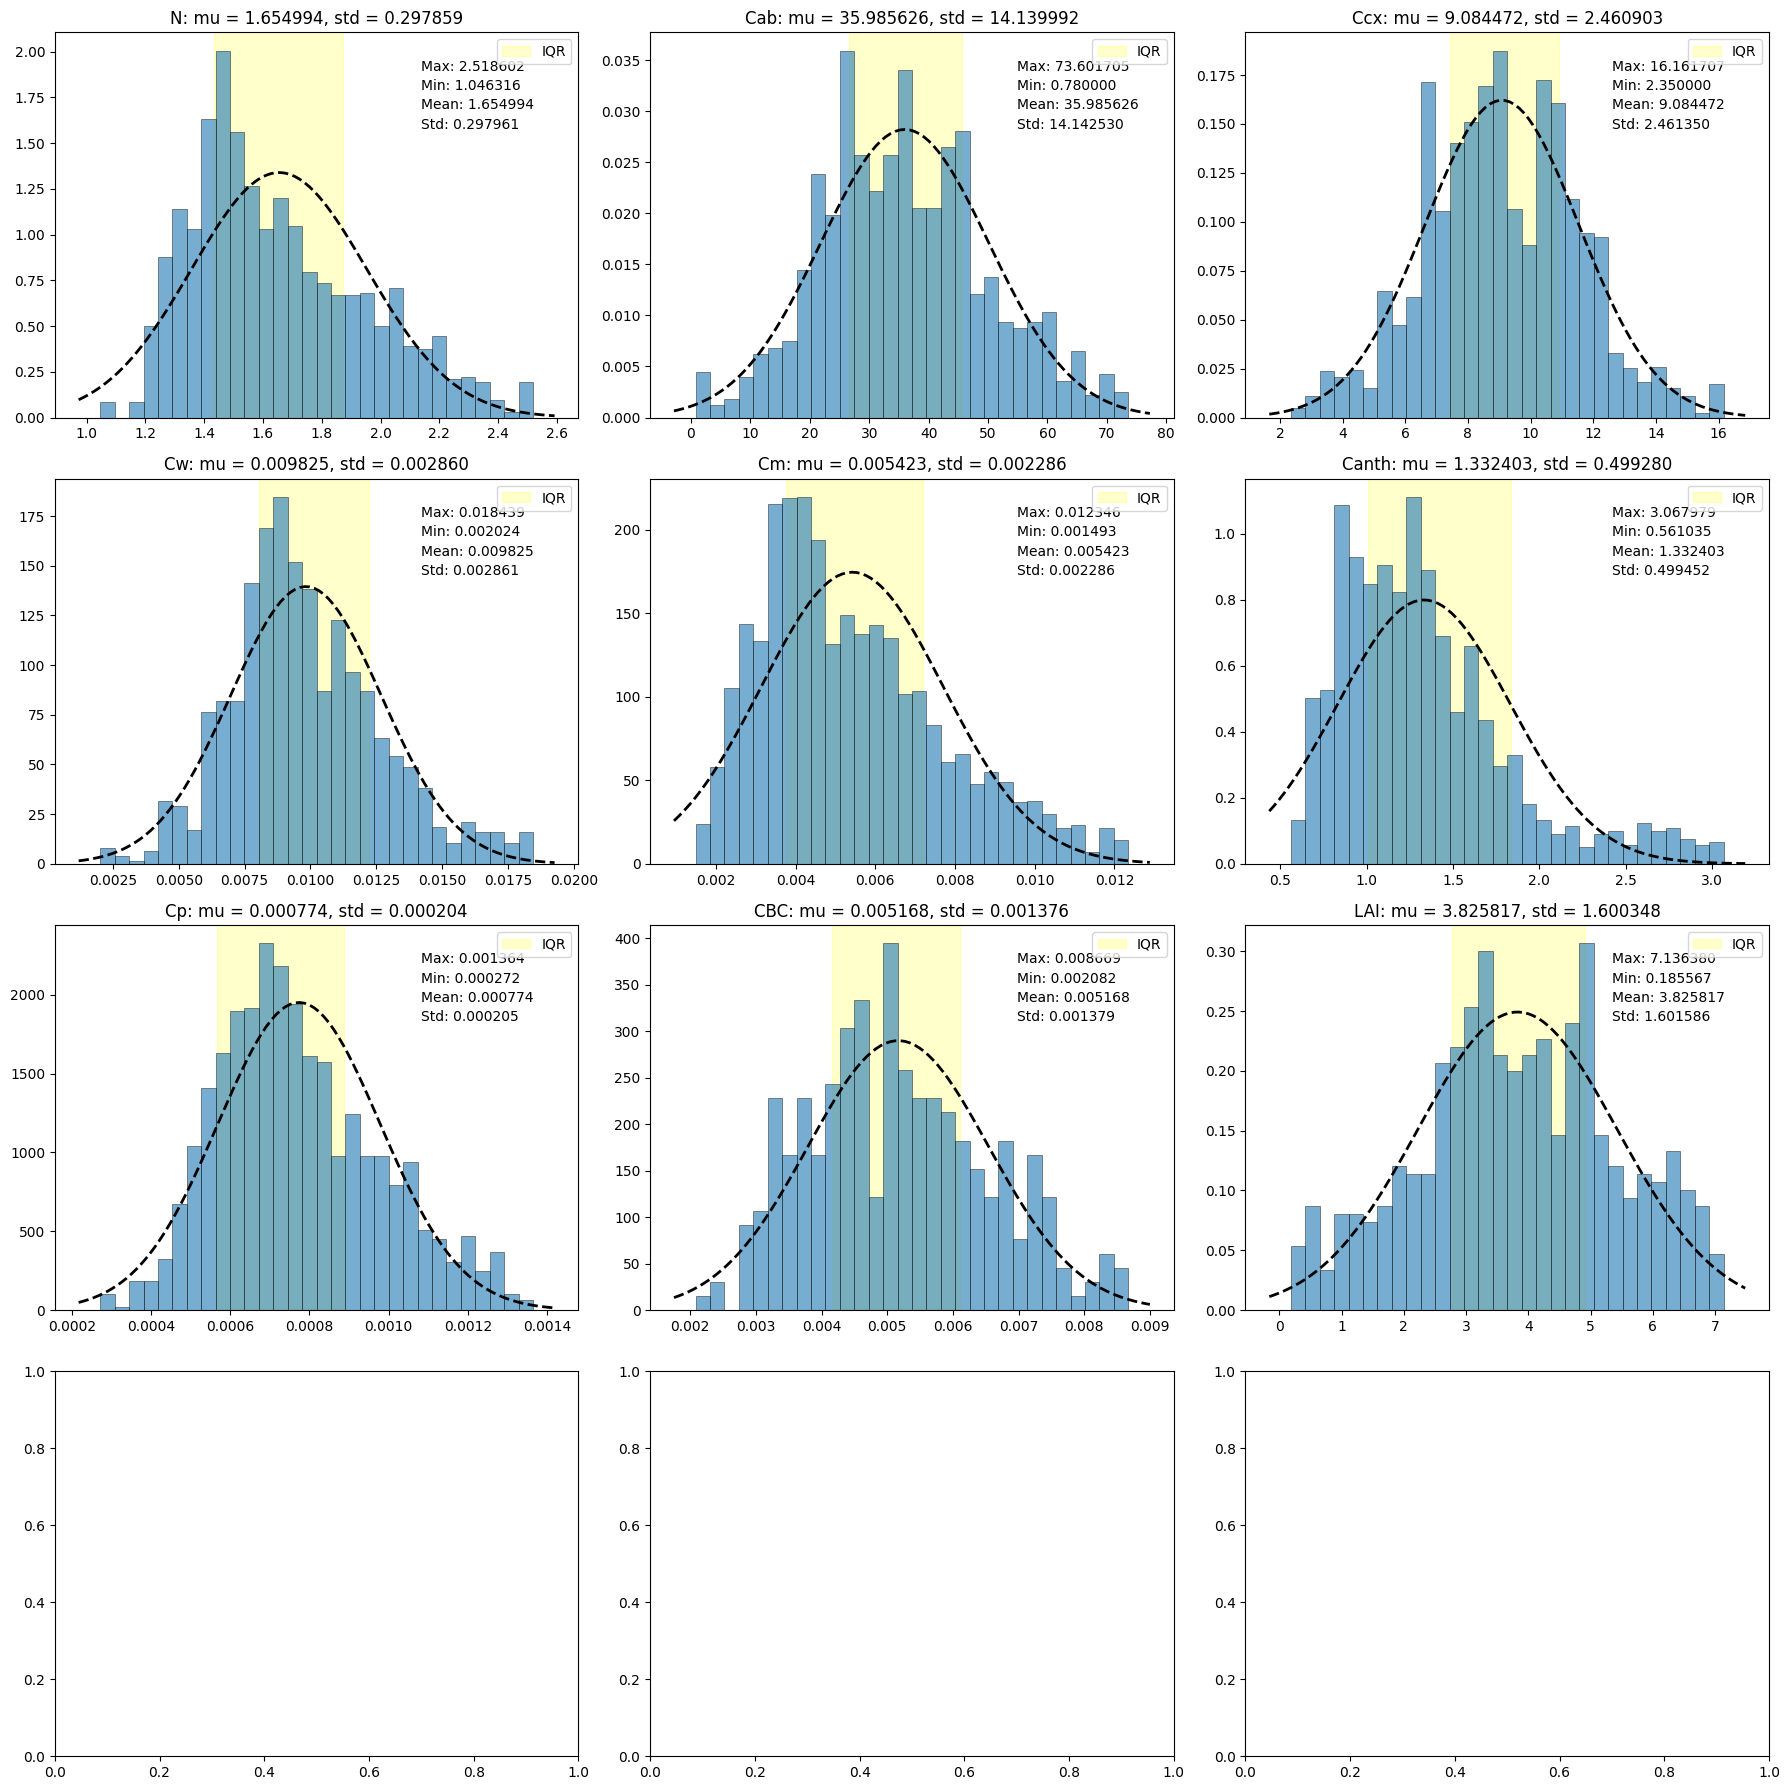

In [13]:
# Use the function
plot_and_fit("D:\\二学位非软件文件\\GREAT\\dataset\\processed_data.csv")